In [6]:
import ee

# Initialize the Earth Engine API.
ee.Authenticate(force = True)
ee.Initialize(project='ee-hadat')


Successfully saved authorization token.


In [7]:
import ee
ee.Initialize()

# =============================================================================
# FUNCTIONS
# =============================================================================

def get_sentinel_collection(start_date, end_date, roi):
    """
    Loads the Sentinel-2 collection, applies initial filters and cloud masking.
    """
    # Advance dates by ±8 days
    s_date = start_date.advance(-8, 'day')
    e_date = end_date.advance(8, 'day')
    
    cs_plus = ee.ImageCollection('GOOGLE/CLOUD_SCORE_PLUS/V1/S2_HARMONIZED')
    qa_band = 'cs'
    clear_threshold = 0.5
    
    sentinel2 = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
                 .filterBounds(roi)
                 .filterDate(s_date, e_date)
                 .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 85))
                 .linkCollection(cs_plus, [qa_band]))
    
    cloud_masked = sentinel2.map(
        lambda img: img.updateMask(img.select(qa_band).gte(clear_threshold)).clip(roi)
    )
    
    return cloud_masked

def cloud_masking_sentinel(image):
    """
    Alternative cloud masking for Sentinel-2 using QA60 and SCL bands.
    """
    qa = image.select('QA60')
    scl = image.select('SCL')
    # Create cloud mask: no cloud (bit 10 in QA60 is 0) and remove certain SCL values.
    cloud_mask = (qa.bitwiseAnd(1 << 10).eq(0)
                  .And(scl.neq(3))
                  .And(scl.neq(8))
                  .And(scl.neq(9))
                  .And(scl.neq(10)))
    return image.updateMask(cloud_mask)

def get_non_cloud_ndvi_collection(cloud_free_collection):
    """
    From a cloud-free collection, sets a 'date_only' property,
    then creates daily mosaics and computes NDVI.
    """
    # Set the property 'date_only' for each image.
    sentinel2 = cloud_free_collection.map(
        lambda image: image.set('date_only', ee.Date(image.get('system:time_start')).format('YYYY-MM-dd'))
    )
    
    # Get unique dates.
    unique_dates = sentinel2.distinct(['date_only'])
    
    def mosaic_for_date(date_image):
        date = ee.Date(date_image.get('system:time_start'))
        date_only = ee.String(date_image.get('date_only'))
        # Filter images for the same day.
        daily_images = sentinel2.filter(ee.Filter.eq('date_only', date_only))
        # Mosaic images and compute NDVI (NDVI = (B8 - B4) / (B8 + B4)).
        mosaic = (daily_images.mosaic()
                  .normalizedDifference(['B8', 'B4'])
                  .rename('NDVI'))
        return mosaic.set('system:time_start', date.millis())
    
    mosaic_collection = unique_dates.map(mosaic_for_date)
    return ee.ImageCollection(mosaic_collection)

def separate_collections(ndvi_collection):
    """
    Separates a collection into cloud-free and cloudy subsets based on the 
    'CLOUDY_PIXEL_PERCENTAGE' property.
    """
    cloud_free = ndvi_collection.filter(ee.Filter.lte('CLOUDY_PIXEL_PERCENTAGE', 2))
    cloudy = ndvi_collection.filter(ee.Filter.gt('CLOUDY_PIXEL_PERCENTAGE', 2))
    return {'cloudFree': cloud_free, 'cloudy': cloudy}

def calculate_8day_composites(image_collection, start_date, end_date, exclude_date):
    """
    For each 8-day period, creates a composite NDVI image. If no images exist 
    in the period, returns an empty image with a placeholder time.
    """
    days_step = 8
    start = ee.Date(start_date)
    end = ee.Date(end_date)
    millis_step = days_step * 24 * 60 * 60 * 1000
    list_of_dates = ee.List.sequence(start.millis(), end.millis(), millis_step)
    
    def composite_for_millis(millis):
        composite_center = ee.Date(millis)
        composite_start = composite_center.advance(-8, 'day')
        composite_end = composite_center.advance(8, 'day')
        period_collection = image_collection.filterDate(composite_start, composite_end)
        composite_image = ee.Algorithms.If(
            period_collection.size().gt(0),
            (period_collection.median()
             .normalizedDifference(['B8', 'B4'])
             .rename('NDVI')
             .set('system:time_start', composite_center.millis())),
            ee.Image().set('system:time_start', exclude_date)
        )
        return composite_image
    
    composites = list_of_dates.map(composite_for_millis)
    return ee.ImageCollection(composites)

def calculate_ndvi_collection(image_collection):
    """
    Computes NDVI for each image in the collection.
    """
    def calc_ndvi(image):
        ndvi = (image.normalizedDifference(['B8', 'B4'])
                .rename('NDVI')
                .copyProperties(image, ['system:time_start']))
        return ndvi
    return image_collection.map(calc_ndvi)

# --- Display functions (for interactive use) ---
def display_sentinel(image_collection, layer_name):
    """
    Prints information for each Sentinel-2 image that contains band 'B4'.
    """
    image_list = image_collection.toList(image_collection.size())
    size = image_collection.size().getInfo()
    for i in range(size):
        image = ee.Image(image_list.get(i))
        has_bands = image.bandNames().contains('B4').getInfo()
        if has_bands:
            date = ee.Date(image.get('system:time_start')).format('YYYY-MM-dd').getInfo()
            print(f'Layer: {layer_name} {date} - Sentinel image available.')

def display_ndvi(image_collection, layer_name):
    """
    Prints information for each NDVI image in the collection.
    """
    image_list = image_collection.toList(image_collection.size())
    size = image_collection.size().getInfo()
    for i in range(size):
        image = ee.Image(image_list.get(i))
        has_bands = image.bandNames().contains('NDVI').getInfo()
        if has_bands:
            date = ee.Date(image.get('system:time_start')).format('YYYY-MM-dd').getInfo()
            print(f'Layer: {layer_name} {date} - NDVI image available.')

import ee
import os
import requests
import tempfile
import zipfile
import shutil
import time

ee.Initialize()

def download_ndvi(ndvi_composites, big_folder, roi, ndvi_name, roi_name, folder_name):
    """
    Downloads each NDVI image from the collection as a ZIP file into a temporary folder,
    unzips it to extract the GeoTIFF image, moves the TIFF to the destination folder,
    and removes the temporary folder afterwards.
    """
    image_list = ndvi_composites.toList(ndvi_composites.size())
    size = ndvi_composites.size().getInfo()
    out_folder = os.path.join(big_folder, roi_name)
    out_folder = os.path.join(out_folder, folder_name)
    if not os.path.exists(out_folder):
        os.makedirs(out_folder)

    for i in range(size):
        image = ee.Image(image_list.get(i))
        # Ensure the image has an NDVI band.
        if image.bandNames().contains('NDVI').getInfo():
            date_str = ee.Date(image.get('system:time_start')).format('YYYY-MM-dd').getInfo()
            params = {
                'scale': 10,
                'region': roi,
                'fileFormat': 'ZIP',  # Request a ZIP file
                'maxPixels': 1e13
            }
            download_url = image.select('NDVI').getDownloadURL(params)
            print('Downloading NDVI for date:', date_str)
            print('Download URL:', download_url)
            
            # Create a temporary folder
            temp_dir = tempfile.mkdtemp()
            zip_path = os.path.join(temp_dir, f"{ndvi_name}{date_str}.zip")
            
            try:
                response = requests.get(download_url, timeout=120)
            except Exception as e:
                print(f"Error fetching URL for {date_str}: {e}")
                shutil.rmtree(temp_dir)
                continue

            if response.status_code == 200:
                with open(zip_path, 'wb') as f:
                    f.write(response.content)
                print(f"Downloaded ZIP file: {zip_path}")
                
                # Unzip the file
                try:
                    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
                        zip_ref.extractall(temp_dir)
                    print(f"Unzipped file in {temp_dir}")
                    
                    # Search for the first .tif file in the temporary folder.
                    tif_files = [f for f in os.listdir(temp_dir) if f.lower().endswith('.tif')]
                    if tif_files:
                        tif_file = tif_files[0]
                        final_path = os.path.join(out_folder, f"{ndvi_name}{date_str}.tif")
                        shutil.move(os.path.join(temp_dir, tif_file), final_path)
                        print(f"Moved GeoTIFF to {final_path}")
                    else:
                        print(f"No TIFF file found in ZIP for date: {date_str}")
                except Exception as e:
                    print(f"Error unzipping file for {date_str}: {e}")
            else:
                print(f"Failed to download NDVI image for date: {date_str} (Status code: {response.status_code})")
            
            # Remove the temporary folder regardless of outcome.
            try:
                shutil.rmtree(temp_dir)
                print(f"Removed temporary folder: {temp_dir}")
            except Exception as e:
                print(f"Error removing temporary folder {temp_dir}: {e}")
            time.sleep(2)  # Pause between downloads if needed

# Example usage:
# roi = ee.Geometry.Polygon([...])
# ndvi_composites = get_non_cloud_ndvi_collection(cloud_free_collection)  # Assume you have this collection.
# big_folder = "/path/to/download/folder"
# download_ndvi(ndvi_composites, big_folder, roi, 'ndvi8days_', 'thaiphuc_ndvi8days')


def download_ndvi_to_asset(ndvi_composites, big_folder, roi, ndvi_name, folder_name, asset_path):
    """
    Downloads each NDVI image from the collection using the asset path information
    as part of the file name (for local storage). Since assets are stored on EE servers,
    this function simply uses the asset_path string for naming.
    """
    image_list = ndvi_composites.toList(ndvi_composites.size())
    size = ndvi_composites.size().getInfo()
    if not os.path.exists(os.path.join(big_folder, folder_name)):
        os.makedirs(os.path.join(big_folder, folder_name))
    for i in range(size):
        image = ee.Image(image_list.get(i))
        if image.bandNames().contains('NDVI').getInfo():
            date_str = ee.Date(image.get('system:time_start')).format('YYYY-MM-dd').getInfo()
            # Build a file name using the asset path information.
            filename = os.path.join(big_folder, f"{folder_name}/{ndvi_name}{date_str}.tif")
            params = {
                'scale': 10,
                'region': roi,
                'fileFormat': 'GeoTIFF',
                'maxPixels': 1e13
            }
            download_url = image.select('NDVI').getDownloadURL(params)
            print('Downloading NDVI asset for date:', date_str)
            print('Download URL:', download_url)
            response = requests.get(download_url)
            if response.status_code == 200:
                with open(filename, 'wb') as f:
                    f.write(response.content)
                print(f"Downloaded NDVI asset saved as {filename}")
            else:
                print(f"Failed to download NDVI asset for date: {date_str} (Status code: {response.status_code})")


def create_grid(roi):
    """
    Creates a grid (10x10 cells) covering the given region.
    """
    bounds = roi.bounds()
    bbox_coords = ee.List(bounds.coordinates().get(0))
    x_min = ee.Number(ee.List(bbox_coords.get(0)).get(0))
    y_min = ee.Number(ee.List(bbox_coords.get(0)).get(1))
    x_max = ee.Number(ee.List(bbox_coords.get(2)).get(0))
    y_max = ee.Number(ee.List(bbox_coords.get(2)).get(1))
    
    x_step = x_max.subtract(x_min).divide(20)
    y_step = y_max.subtract(y_min).divide(20)
    x_steps = ee.List.sequence(x_min, x_max.subtract(x_step), x_step)
    y_steps = ee.List.sequence(y_min, y_max.subtract(y_step), y_step)
    
    def make_cells(x_start):
        def cell_for_y(y_start):
            x_end = ee.Number(x_start).add(x_step)
            y_end = ee.Number(y_start).add(y_step)
            cell = ee.Feature(ee.Geometry.Rectangle([x_start, y_start, x_end, y_end]))
            return cell.intersection(roi, 1)  # using an error margin of 1
        return y_steps.map(cell_for_y)
    
    grid_cells = x_steps.map(make_cells).flatten()
    return ee.FeatureCollection(grid_cells)

def create_grid_mask(roi, percentage, grid, seed):
    """
    Creates a grid-based mask by assigning random values to each grid cell and then
    selecting a percentage of the cells.
    """
    random_image = ee.Image.random(seed).clip(roi)
    
    def set_random(feature):
        mean_random = random_image.reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=feature.geometry(),
            scale=10,
            maxPixels=1e13
        ).get('random')
        return feature.set('random', mean_random)
    
    grid_with_random = grid.map(set_random)
    total_grids = grid_with_random.size()
    selected_count = ee.Number(total_grids).multiply(percentage).divide(100).round()
    sorted_grid = grid_with_random.sort('random')
    selected_grid = sorted_grid.limit(selected_count)
    mask = (selected_grid.reduceToImage(properties=['random'], reducer=ee.Reducer.first())
            .unmask(0))
    return mask

def create_cloud_simulated_ndvi_collections(image_collection, cloud_mask_percentage, roi):
    """
    For each image, simulates cloud coverage using a grid mask and returns two 
    collections: one with the clouded NDVI (masked where clouds occur) and one 
    with the extracted cloud NDVI (only clouds).
    """
    grid = create_grid(roi)
    
    def process_image(image):
        seed = image.get('system:time_start')
        cloud_mask = create_grid_mask(roi, cloud_mask_percentage, grid, seed)
        # In Python, use .Not() to get the inverse of a mask.
        clouded_ndvi = image.updateMask(cloud_mask.Not())
        extracted_ndvi = image.updateMask(cloud_mask)
        clouded_ndvi = clouded_ndvi.set('system:time_start', image.get('system:time_start'))
        extracted_ndvi = extracted_ndvi.set('system:time_start', image.get('system:time_start'))
        return {'clouded': clouded_ndvi, 'extracted': extracted_ndvi}
    
    def get_clouded(image):
        return ee.Image(process_image(image)['clouded'])
    
    def get_extracted(image):
        return ee.Image(process_image(image)['extracted'])
    
    clouded_collection = image_collection.map(get_clouded)
    extracted_collection = image_collection.map(get_extracted)
    
    return {
        'cloudedCollection': ee.ImageCollection(clouded_collection),
        'extractedCollection': ee.ImageCollection(extracted_collection)
    }

# =============================================================================
# MAIN EXECUTION
# =============================================================================

# Define time period and region of interest.
start_date = ee.Date('2023-01-01')
end_date = ee.Date('2023-02-01')
exclude_date = ee.Date('1900-01-01').millis()

roi = ee.Geometry.Polygon(
    [[[11855180.0, 2328782.140517925],
      [11855180.0, 2335016.8225009246],
      [11851160.0, 2335016.8225009246],
      [11851160.0, 2328782.140517925],
      [11855180.0, 2328782.140517925]]],
    'EPSG:3857'
)

big_folder = "/mnt/data1tb/LSTRetrieval/Code/download_data"
roi_name = "ThaiPhuc_ThaiThuy_ThaiBinh"

# (Optional) If you have functions to get district or commune geometries, define them here.

# ---------------------------------------------------------------------------
# Run processing steps
# ---------------------------------------------------------------------------
# 1. Load Sentinel-2 collection and mask clouds.
sentinel_collection = get_sentinel_collection(start_date, end_date, roi)
#print('Sentinel Collection loaded.')

# 2. Separate the collection into cloud-free and cloudy subsets.
collections = separate_collections(sentinel_collection)
print('Cloudy images count:', collections['cloudy'].size().getInfo())
print('Non-cloudy images count:', collections['cloudFree'].size().getInfo())

# 3. Create NDVI composites.
ndvi_composites_cloudy = calculate_8day_composites(collections['cloudy'], start_date, end_date, exclude_date)
ndvi_composites_non_cloud = get_non_cloud_ndvi_collection(collections['cloudFree'])

# (Optional) Display information about collections.
# display_sentinel(sentinel_collection, "Sentinel")
# display_ndvi(ndvi_composites_cloudy, "Cloudy NDVI")
# display_ndvi(ndvi_composites_non_cloud, "Non-Cloud NDVI")

# 4. Export NDVI composites to Google Drive.
download_ndvi(ndvi_composites_cloudy, big_folder, roi, 'ndvi8days_', roi_name, f'{roi_name.split("_")[0]}_ndvi8days')
download_ndvi(ndvi_composites_non_cloud, big_folder, roi, 'ndvinoncloud_', roi_name, f'{roi_name.split("_")[0]}_ndvinoncloud')

# (Optional) To export to an asset instead:
# export_ndvi_to_asset(ndvi_composites_cloudy, roi, 'ndvi8days_', 'users/your_asset_folder')
# export_ndvi_to_asset(ndvi_composites_non_cloud, roi, 'ndvinoncloud_', 'users/your_asset_folder')


Cloudy images count: 6
Non-cloudy images count: 1
Download URL: https://earthengine.googleapis.com/v1/projects/172099900522/thumbnails/42ce78c4970830fc196311c5762aa2ee-47db6b9dd9939ad7ee52f80ad562738e:getPixels
Downloaded ZIP file: /tmp/tmpspgk0q8q/ndvi8days_2023-01-01.zip
Unzipped file in /tmp/tmpspgk0q8q
Moved GeoTIFF to /mnt/data1tb/LSTRetrieval/Code/download_data/ThaiPhuc_ThaiThuy_ThaiBinh/ThaiPhuc_ndvi8days/ndvi8days_2023-01-01.tif
Removed temporary folder: /tmp/tmpspgk0q8q
Download URL: https://earthengine.googleapis.com/v1/projects/172099900522/thumbnails/26472902e399e3c10b26efaf3829b54f-d79a2dbaafd240f581041b6c0a2291f2:getPixels
Downloaded ZIP file: /tmp/tmpwm80p1n7/ndvi8days_2023-01-09.zip
Unzipped file in /tmp/tmpwm80p1n7
Moved GeoTIFF to /mnt/data1tb/LSTRetrieval/Code/download_data/ThaiPhuc_ThaiThuy_ThaiBinh/ThaiPhuc_ndvi8days/ndvi8days_2023-01-09.tif
Removed temporary folder: /tmp/tmpwm80p1n7
Download URL: https://earthengine.googleapis.com/v1/projects/172099900522/thumbnai

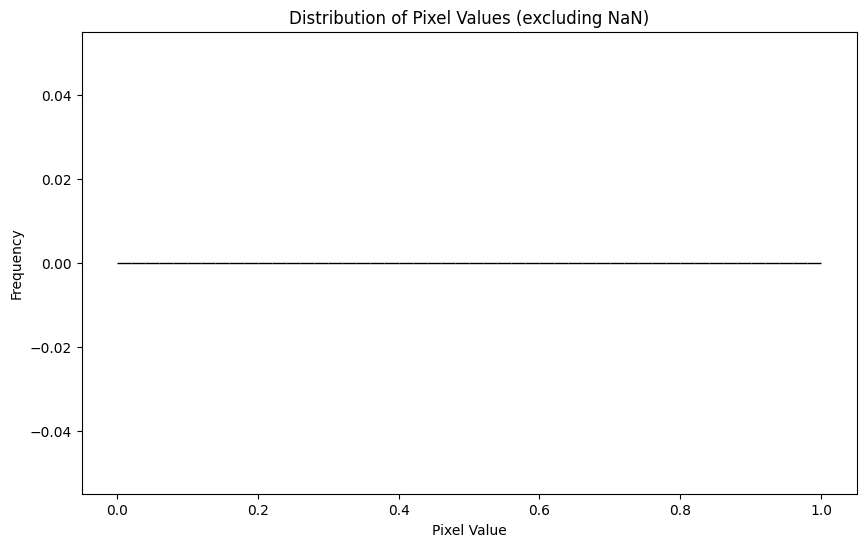

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio

# Open the TIFF image (assumes a single band image)
with rasterio.open('/mnt/data1tb/LSTRetrieval/Data/drive-download-20250306T091015Z-001/ndvi8days_2023-01-17.tif') as src:
    # Read the first band (change the index if you need a different band)
    data = src.read(1)

# Flatten the 2D array into a 1D array
pixel_values = data.flatten()

# Remove NaN values from the pixel data
valid_pixels = pixel_values[~np.isnan(pixel_values)]

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(valid_pixels, bins=50, edgecolor='black')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.title('Distribution of Pixel Values (excluding NaN)')
plt.show()
